In [ ]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

In [68]:
#From signac
import signac
meth_name_val_list = [1, 2, 3, 4, 5, 6]

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": {"$gte": 1},
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": 1,
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 15,
                 "param_name_str":{"$exists": False},
                 "meth_name_val": {"$in": [1,2,3,5,6]}}
# "param_name_str":{"$exists": False}
project = signac.get_project()
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, save_csv)
plotters = Plotters(analyzer, save_figs)

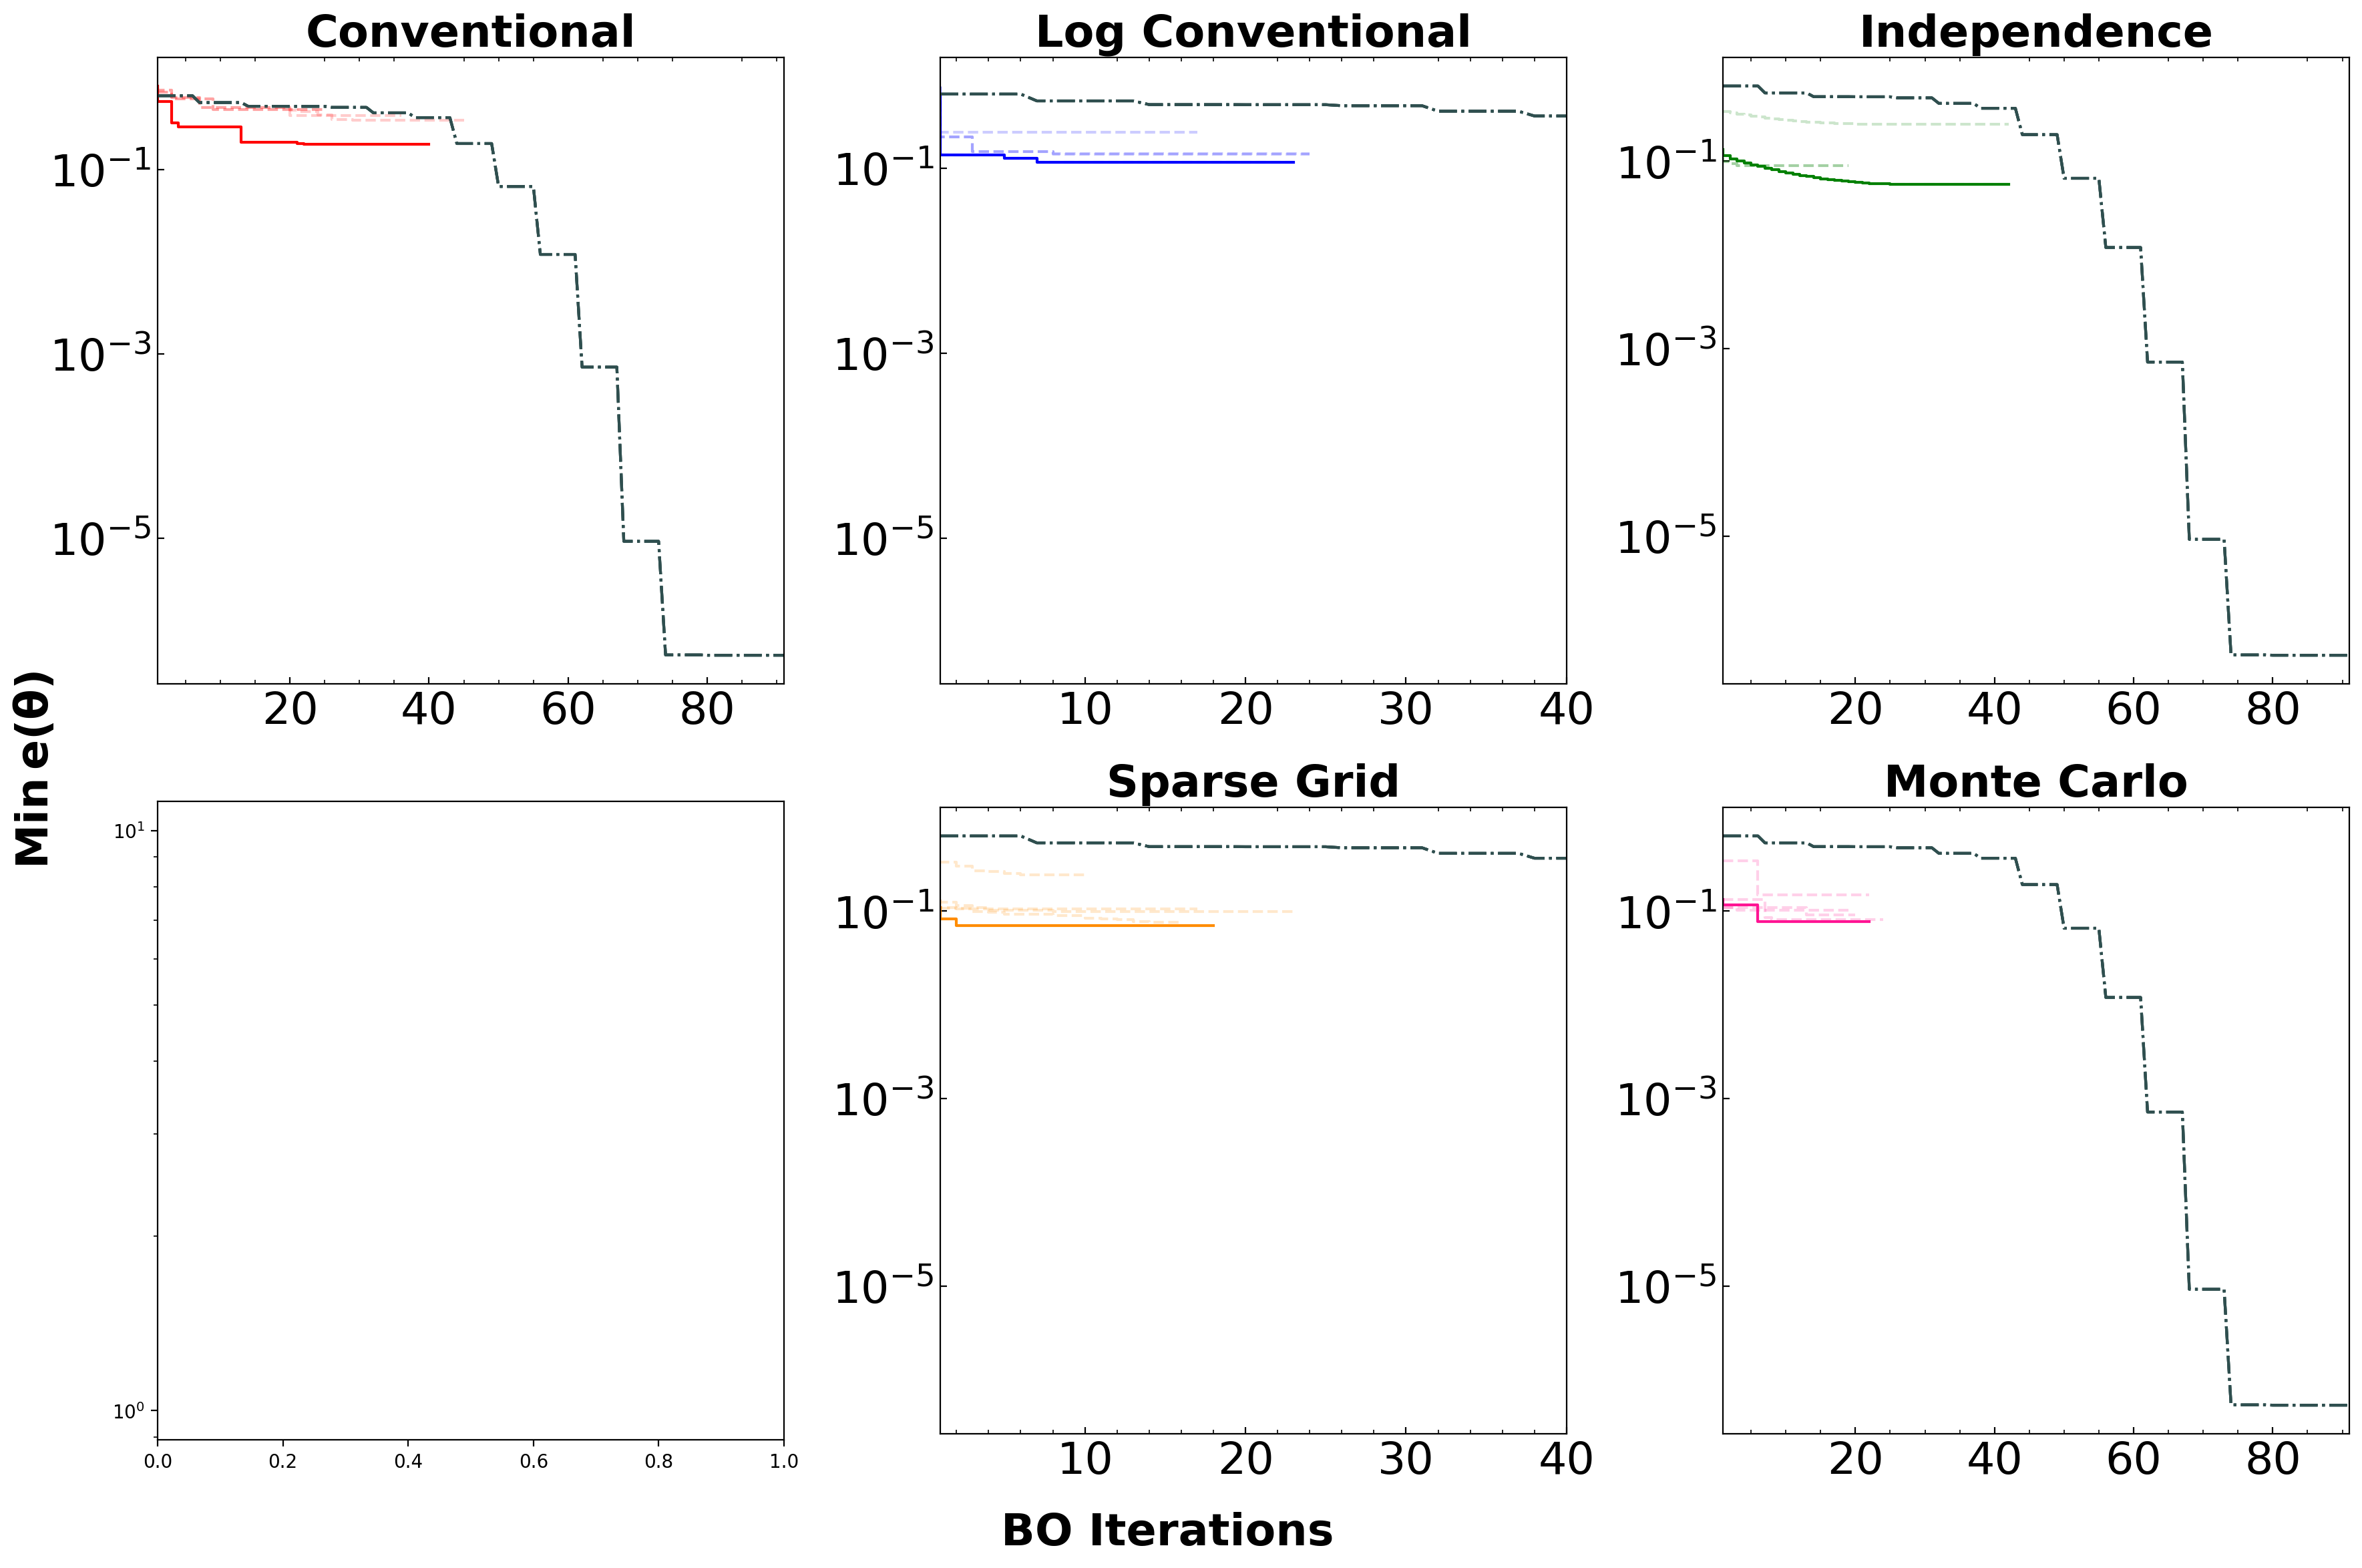

In [69]:
plotters.plot_one_obj_all_methods("min_sse")

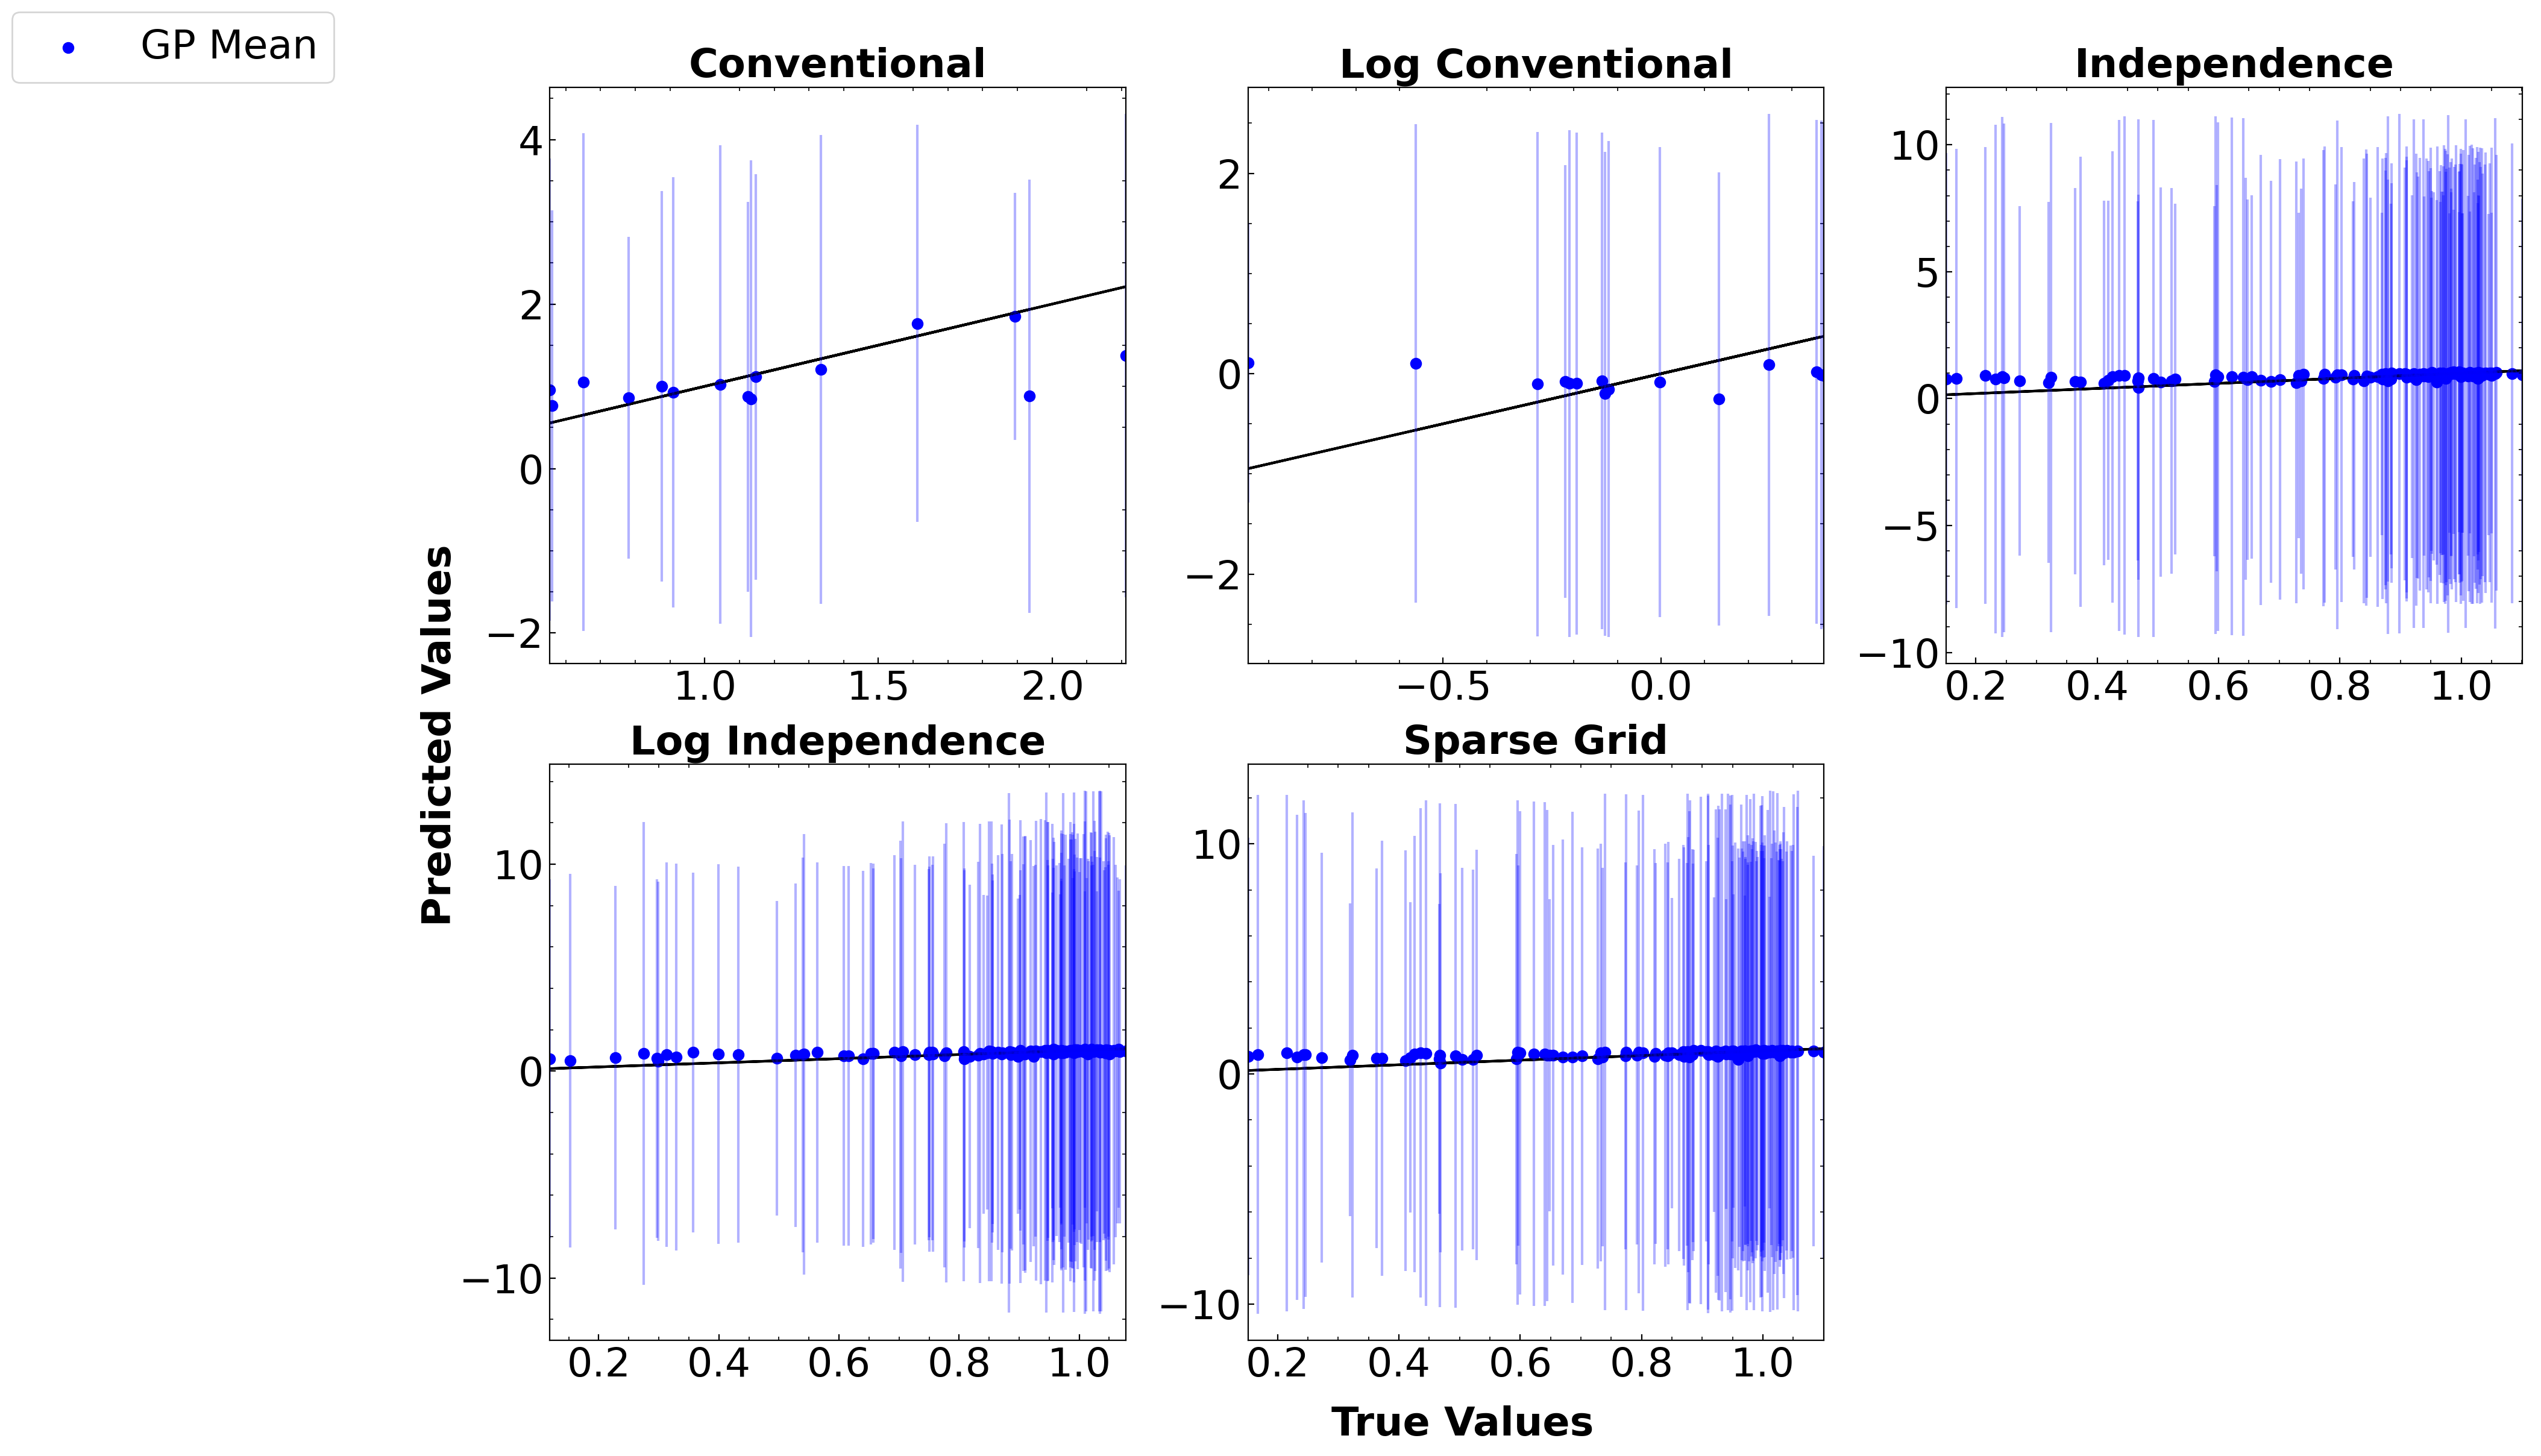

In [70]:
plotters.make_parity_plots()

In [71]:
# df_all_jobs, job_list, theta_true = analyzer.get_df_all_jobs()
df_best, job_list_best = analyzer.get_best_data()

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)
    
df_best

4ee80ad2e307c792b2989790b3c62964
ad3a207a154617add96a216a3ef44d4f
ba087639cc68dd39b4d4f8c1720188c2
16ed9e398eb61022c2e21d09159dce01
f45528f717f710993bab841f6cfcdc97


,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,...,Speed,Time/Iter,EP Method Val,MSE,BO Method,Job ID,Max Evals,Termination,Total Run Time,L2 Norm Theta
223,5,25,0.401925,1.0,4.259601e-01,"[3.0, 0.0001, 5.0, 0.31026976653511, 5.0]",0.439743,0.189812,"[1.86222206793725, 0.5121495352140318, 0.52332...",0.189812,...,0.924147,22.113720,CONSTANT,0.018981,A1,4ee80ad2e307c792b2989790b3c62964,40,obj-regret,884.548817,0.508557
298,3,8,-2.071886,1.0,1.298300e-01,"[1.8696294232595758, 0.6267817763913723, 0.952...",-2.097910,-2.159211,"[1.8602470170279806, 0.5954065665906537, 0.553...",-2.159211,...,0.013273,33.677541,CONSTANT,0.011542,B1,ad3a207a154617add96a216a3ef44d4f,23,obj-regret,774.583438,0.359801
452,3,27,0.383938,1.0,6.657699e-02,"[1.8214674956231052, 0.38923008608499865, 1.23...",0.229421,0.057124,"[1.3151118478910742, 0.3798992883680157, 0.494...",0.057124,...,1.700400,106.510600,CONSTANT,0.005712,A2,ba087639cc68dd39b4d4f8c1720188c2,42,obj-regret,4473.445204,0.721779
67,1,3,0.485947,1.0,-1.992855e-04,"[0.9531877380528474, 0.22753329340702563, -4.7...",0.331946,0.070613,"[1.1131169560794347, 0.4373322893667093, 0.351...",0.070613,...,NaN,76.772477,CONSTANT,0.007061,C2,16ed9e398eb61022c2e21d09159dce01,18,ei-obj-regret,1381.904584,0.913334
621,4,7,0.237886,1.0,2.901014e-10,"[2.629787582458632, 0.09166478524005445, -3.11...",0.158980,0.077907,"[2.617028694050296, 0.0001, -3.002649517093873...",0.077907,...,NaN,54.199767,CONSTANT,0.007791,D2,f45528f717f710993bab841f6cfcdc97,22,ei-obj,1192.394882,4.882774


In [ ]:
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_results = ls_analyzer.least_squares_analysis()
ls_results_sort = ls_results.sort_values(by=['Min Obj Cum.', 'Iter'], ascending=True)
ls_runs = ls_results_sort.drop_duplicates(subset="Run", keep='first')
ls_runs
# ls_results
# ls_results[ls_results["Run"] == 1]

In [ ]:
tot_runs = 1000
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_analyzer.num_x = 6
local_mins = ls_analyzer.categ_min(tot_runs)
local_mins

In [ ]:
print(local_mins["Theta Min Obj Cum."].values)

In [ ]:
plotters.plot_hypers(job_list_best[1], title = None)

In [ ]:
plotters.plot_objs_all_methods(["min_sse", "sse"])

In [ ]:
plotters.plot_thetas(job_list_best[0], "min_sse", title = None)

In [ ]:
# title = "Heat Map Pair " + z_choice
levels = [100, 100, 100, 100, 100, 100]
pair = 0
z_choice = "sse_mean"
plotters.plot_hms_all_methods(pair, z_choice, levels, log_data = False, title = None)

In [ ]:
levels = [100, 100, 100, 100]
pair = 0
z_choice = ["sse_sim", "sse_mean", "sse_var", "ei"]
plotters.plot_hms_gp_compare(job_list_best[0], df_best["Run Number"].iloc[0], df_best["BO Iter"].iloc[0], 
                             pair, z_choice, levels, log_data = False, title = None)

In [ ]:
#Make Heat maps for all pairs
z_choices = ["sse_sim", "sse_mean", "sse_var", "ei"]
levels = [100,100,100,100]

#Loop over best jobs
for i in range(len(job_list_best)):   
    #Get jobs, runs, and iters to examine
    job = job_list_best[i]
    run_num = df_best["Run Number"].iloc[i]
    bo_iter = df_best["BO Iter"].iloc[i]
    
    #Back out number of parameters
    string_val = df_best["Theta Min Obj"].iloc[0]
    try:
        numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    except:
        numbers = [float(num) for num in string_val]
        
    #Create list of parameter pair combinations
    dim_theta = len(np.array(numbers).reshape(-1, 1))
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    
    #Loop over parameter pairs
    for pair in range(pairs):
        plotters.plot_hms_gp_compare(job, run_num, bo_iter, pair, z_choices, levels)